In [20]:
# Python 3 Enviornment
# Importing our necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import os

print(os.listdir(r"Data"))

['.ipynb_checkpoints', 'BBC News Sample Solution.csv', 'BBC News Test.csv', 'BBC News Train.csv']


In [21]:
# Looking at our data
Trainpath = os.path.join("Data/BBC News Train.csv")

# Load our data
Traindata = pd.read_csv(Trainpath)

# Read our data to review columns, and datapoints
Traindata.head()

# We need to encode our data then save it to a new column
Traindata['category_id'] = Traindata['Category'].factorize()[0]

# Review our dataframe
Traindata.head(10)

# Lets look at our categories and corresponding ID numbers
category_id = Traindata[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

# drop index and review
category_id.reset_index(drop=True, inplace=True)

# index matches our cateogory_id
category_id

,Category,category_id
0,business,0
1,tech,1
2,politics,2
3,sport,3
4,entertainment,4


In [22]:
# Create a dictionary that can convert category names into category_id
category_to_id = dict(category_id.values)

# inverse the dict
id_to_category = {v: i for i, v in category_to_id.items()}

<AxesSubplot:xlabel='Category'>

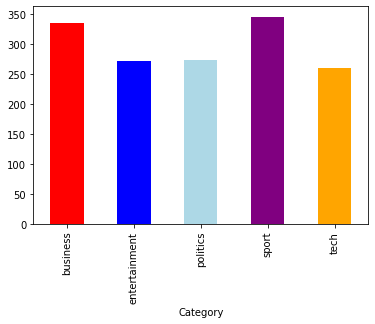

In [23]:
# Sample our data
Traindata.sample(10)

# Count and view our data
Traindata.groupby('Category').category_id.count()

# Bar plot for visualization 
Traindata.groupby('Category').category_id.count().plot.bar(ylim=0,
                                                           color=['red','blue','lightblue',
                                                                 'purple','orange'])

In [25]:
# Bring in our Tfid Vectorizer
    # Sublinear_tf set to True to give returns as freq. of word decreases
    # Min_df is minimum number of documents a word must be present in to be kept
    # norm is to ensure all our feature vectors have a euclidian norm of 1
    # encoding is used by our input text
    # ngram_range to indicate that we want to consider single words ('money', 'business') amd pairs of words ('stock market', 'comedy movies')
    # stop_words set to english for removing all common pronouns ('a', 'he', 'it')
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', 
                        ngram_range=(1,2), stop_words='english')

features = tfidf.fit_transform(Traindata.Text).toarray()
# turns our texts into features 

# Assign our labels
labels = Traindata.category_id
labels

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: category_id, Length: 1490, dtype: int64

In [26]:
# Check our feauture shapes. How many features are there?
print(features.shape)

sorted(category_to_id.items())

(1490, 4782)


[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

In [27]:
from sklearn.feature_selection import chi2

N = 5 # Looking at the top five words foe each category

# For each category find words that are highly correlated with it
# Gets the category and id from sorted list
for Category, category_id in sorted(category_to_id.items()):
    # Do chi2 analysis of all items in this category
    features_chi2 = chi2(features, labels == category_id)
    # Sorts the indicies of features_chi2
    indicies = np.argsort(features_chi2[0])
    # Converts indicies to feature names (increasing chi2 order)
    feature_names = np.array(tfidf.get_feature_names())[indicies]
    # List of single word features (in increasing order of chi2 stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # List for two-words (in increasing order of chi2 stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("# '{}':".format(Category))
    
    # Prints 5 unigrams with highest chi squared stat
    print(" . Most Correlated unigrams:\n    .{}".format('\n    .'.join(unigrams[-N:])))
    # Prints 5 bigrams with highest chi squared stat
    print(" . Most Correlated biigrams:\n    .{}".format('\n    .'.join(bigrams[-N:])))

    

# 'business':
 . Most Correlated unigrams:
    .economy
    .oil
    .growth
    .bank
    .shares
 . Most Correlated biigrams:
    .chief executive
    .oil prices
    .stock market
    .economic growth
    .analysts said
# 'entertainment':
 . Most Correlated unigrams:
    .awards
    .album
    .singer
    .actor
    .film
 . Most Correlated biigrams:
    .film festival
    .won best
    .best film
    .los angeles
    .box office
# 'politics':
 . Most Correlated unigrams:
    .tories
    .party
    .blair
    .election
    .labour
 . Most Correlated biigrams:
    .mr brown
    .general election
    .prime minister
    .tony blair
    .mr blair
# 'sport':
 . Most Correlated unigrams:
    .season
    .injury
    .coach
    .match
    .cup
 . Most Correlated biigrams:
    .year old
    .world cup
    .grand slam
    .champions league
    .australian open
# 'tech':
 . Most Correlated unigrams:
    .microsoft
    .computer
    .technology
    .software
    .users
 . Most Correlated biigr

In [8]:
features_chi2

(array([0.15673482, 0.36024914, 0.61091723, ..., 0.71520008, 0.03542925,
        0.00574587]),
 array([0.69218066, 0.5483679 , 0.43444266, ..., 0.3977229 , 0.85069904,
        0.939577  ]))

In [9]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationaly expensive
# Gets the length down to 30%
Samp_size = int(len(features) * 0.3)
np.random.seed(0)

# Randomly selects 30% of samples
indicies = np.random.choice(range(len(features)), size=Samp_size, replace=False)

# Array of all projected features of 30% of Randomly chosen samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indicies])

In [10]:
my_id = 0 # selects category_id

projected_features[(labels[indicies] == my_id).values]


array([[ -7.038503  ,  -4.14367   ],
       [-19.748566  ,  -9.95068   ],
       [ -6.1492243 , -16.122793  ],
       [ -1.2916738 , -10.573231  ],
       [ 13.2152405 ,  24.128468  ],
       [ -4.360479  , -10.647816  ],
       [-23.667856  ,  -1.6449893 ],
       [ -5.9305325 ,  -9.685599  ],
       [-16.936007  , -18.673864  ],
       [-10.032745  , -17.645622  ],
       [ -7.458876  ,  19.998806  ],
       [-10.013162  , -12.671203  ],
       [-19.900597  , -16.374363  ],
       [-16.054462  ,  -9.854694  ],
       [  1.1867887 , -10.946933  ],
       [ -8.533413  , -12.016898  ],
       [-19.37486   , -10.951462  ],
       [ -4.3443885 ,  -8.687464  ],
       [-12.128221  ,  -6.2662225 ],
       [-22.584747  ,  -4.33655   ],
       [ -7.7641163 , -23.668333  ],
       [-15.252922  ,  -3.1900856 ],
       [ -7.2909503 , -14.940962  ],
       [-16.510393  ,  -3.6949914 ],
       [ -7.3642364 ,  -8.158136  ],
       [-19.074492  ,  -5.4731054 ],
       [-14.54014   ,  -5.2991223 ],
 

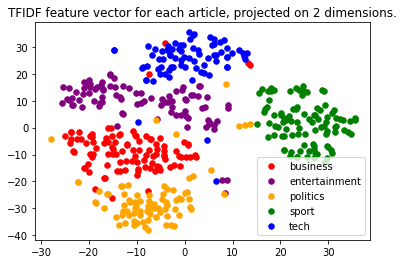

In [11]:
colors = ['red','blue','orange','green','purple']

# Finds points associated with categories and plots them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indicies] == category_id).values]
    plt.scatter(points[:, 0], points[:,1],s=30,c=colors[category_id], label=category)
plt.title('TFIDF feature vector for each article, projected on 2 dimensions.')
plt.legend()
plt.show()

In [12]:
# Import our lin models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# insitialize our models and set params
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [13]:
# Cross validation time BABBBYYYYY
CV = 5

# Creates dataframe that will store the results for all 5 trials of the 3 different models
cv_storage = pd.DataFrame(index=range(CV * len(models)))

# At start all entries are empty
entries = []

In [14]:
for model in models:
    model_name = model.__class__.__name__
    
    # Create 5 models with different 20% test sets, and store their accuracy
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 15 entries (
    # 3 models * 5 cross validations))
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

In [15]:
# Store the new entries into the results dataframe and name its columns
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.838926
1,RandomForestClassifier,1,0.835570
2,RandomForestClassifier,2,0.832215
3,RandomForestClassifier,3,0.889262
4,RandomForestClassifier,4,0.859060
5,MultinomialNB,0,0.966443
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.979866
8,MultinomialNB,3,0.976510
9,MultinomialNB,4,0.963087


model_name
LogisticRegression        0.973154
MultinomialNB             0.969128
RandomForestClassifier    0.851007
Name: accuracy, dtype: float64

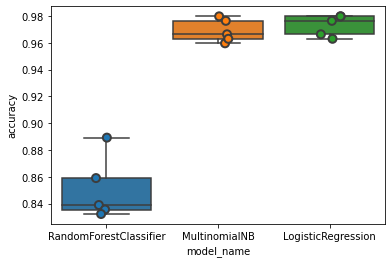

In [19]:
# Visualizing accuracy
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, linewidth=2)

# Group our accuracy scores
cv_df.groupby('model_name').accuracy.mean()

In [31]:
def savanna(x):
    y = x + 5 /3.14
    print(y)

    

In [33]:
print(savanna(10))

11.59235668789809
None
